# **Initial Prompt Engineering – Machine Learning Job Descriptions**

**Purpose**  
This notebook was used for initial prompt engineering to refine the layout and format of the prompt, and to test integration with LangChain’s `PydanticOutputParser` using OpenAI's `GPT-4o` for structured job posting extraction.

---

**Test Data Source**  
- **File:** `test_ml_jobs_us.csv`  
- **Collection Method:** Manual Google search using the query **"ML jobs"**.  
- **Details:**  
  - 8 U.S.-based machine learning job postings.  
  - Posted between **July–August 2025**.  
  - Sourced from LinkedIn, Jobera, Indeed, and company career pages.  
  - Companies such as Instawork, HP, DoorDash, 84.51, Elevance Health, Optum, BNY, and Apple.

---

**Experience Levels in Dataset**  
- **Early Career (3)**  
  - [Instawork](https://www.linkedin.com/jobs/view/ml-engineer-at-instawork-4271043001/)  
  - [HP](https://jobera.com/remote-job/machine-learning-engineering-intern-hp-inc-remote-united-states/?utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic)  
  - [DoorDash](https://www.linkedin.com/jobs/view/machine-learning-intern-%E2%80%93-fall-2025-at-jobright-ai-4274394195/)  

- **Mid-Level (3)**  
  - [84.51](https://www.indeed.com/viewjob?jk=d5f41fb2416a7859&utm_campaign=google_jobs_apply&utm_source=google_jobs_apply&utm_medium=organic)  
  - [Elevance Health](https://careers.elevancehealth.com/ai-machine-learning-scientist/job/34B05DB16D7C0D321ED25FB19D2AAE34)  
  - [Optum](https://www.indeed.com/q-executive-director-machine-learning-jobs.html?vjk=25615d0660caf969&advn=7326412386046683)  

- **Senior (1)**    
  - [BNY](https://www.indeed.com/q-executive-director-machine-learning-jobs.html?vjk=7fc671590e026e56&advn=4877659116924089)  

- **Not Mentioned (1)**  
  - [Apple](https://jobs.apple.com/en-us/details/200584334/senior-applied-scientist-system-intelligence-and-machine-learning-ise?team=SFTWR)  

---

**Final Output**  
- **File:** `parsed_test_ml_jobs_us.csv`  
- **Description:** Structured parsed results generated by the prompt, including job title, experience level, and other key fields as defined in the Pydantic schema.


## **Initial Setup**
The following section:
- Mounts to Google Drive (Colab Only)
- Imports and downloads the appropriate libraries
- Initializes the LangChain wrapped ChatOpenAI model



### **Mount to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Environment Setup**
- Install and import required libraries
- Configure environment for execution (Google Colab or local)
- Load API keys securely

In [ ]:
# !pip install langchain-community
# !pip install openai
# !pip install langchain-openai

In [ ]:
from langchain.output_parsers import PydanticOutputParser     # Parses LLM output into validated Pydantic objects
from langchain.prompts import PromptTemplate                  # Prompt templating for LLM calls
from pydantic import BaseModel, Field, ValidationError        # Data modeling and validation (Pydantic v2 syntax)
from typing import Literal, Annotated, Union                  # Type hints, literal constraints, and union types
import json                                                   # Manual JSON parsing and serialization
from langchain_openai import ChatOpenAI                       # OpenAI model integration via LangChain
import time                                                   # Time-based operations (e.g., retry delays)
import pandas as pd                                           # DataFrame creation, manipulation, and analysis
from tqdm import tqdm                                         # Progress bars for iterative operations
import random                                                 # Randomized elements (e.g., retry jitter)
import os                                                     # OS-level operations (environment variables, file paths)
from cryptography.fernet import Fernet                        # Symmetric encryption/decryption for secure key storage
from sentence_transformers import SentenceTransformer         # Pre-trained sentence embeddings for semantic similarity
from sklearn.metrics.pairwise import cosine_similarity        # Pairwise cosine similarity calculation between embeddings
import seaborn as sns                                          # Statistical data visualization
import matplotlib.pyplot as plt                               # General plotting and charting
import numpy as np                                             # Numerical operations and array manipulation

# Enable tqdm progress bar support for pandas `.progress_apply`
tqdm.pandas()


In [ ]:
from google.colab import userdata

# Load the API key from Colab secret
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

### **Model Initialization**
- Initialize the ChatOpenAI model
- Set model type, temperature, and API configuration

In [ ]:
# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=512,
    model_kwargs={"response_format": {"type": "json_object"}} # Enable JSON mode
)

## **Define the LangChain Parser & Prompt**
- Create the prompt template
- Define the Pydantic Parser with the fields that I would like to extract

### **Schema Definition**
- Define standardized domain categories for ML jobs
- Define types of machine learning methodologies
- Create Pydantic model for structured job info

In [ ]:
# ML Fields by Domain
DomainType = Literal[
    # Health & Life Sciences
    "Healthcare", "Pharmaceuticals", "Biotechnology", "Environmental Science", "Agriculture",
    # Finance & Business
    "Finance", "Insurance", "E-commerce", "Retail", "Advertising", "Marketing", "Real Estate",
    # Tech & Platforms
    "Cybersecurity", "Telecommunications", "Software and Cloud", "Consumer Electronics", "Industrial Electronics",
    # Industry & Engineering
    "Manufacturing", "Energy", "Transportation", "Logistics", "Automotive", "Aerospace", "Construction",
    # Education & Government
    "Education", "Government", "Legal", "Defense",
    # Media & Communications
    "Entertainment", "Gaming", "Social Media", "Sports", "Publishing",
    # Services
    "Human Resources", "Travel and Hospitality", "Customer Service"
]

In [ ]:
# ML by Type
TypeOfML = Literal[
    # Core Paradigms
    "Supervised Learning",
    "Unsupervised Learning",
    "Reinforcement Learning",
    "Self-Supervised Learning",
    "Transfer Learning",
    "Deep Learning",

    # Modeling & Training Techniques
    "Bayesian Modeling",
    "Statistical Modeling",
    "Optimization",
    "Causal Inference",
    "Federated Learning",
    "Multimodal Learning",
    "Meta-Learning",
    "Simulation-Based Learning",
    "Tree-Based Models",
    "Ensemble Learning",

    # Application Areas
    "Embedded ML",
    "Time Series Analysis",
    "Anomaly Detection",
    "Graph Machine Learning",
    "Natural Language Processing",
    "Computer Vision",
    "Speech Recognition",
    "Generative AI",
    "Recommendation Systems",
    "Robotics",
    "Autonomous Systems",
    "Human-Computer Interaction",
    "MLOps"
]

In [ ]:
# Define the output schema
class JobInfo(BaseModel):
    seniority_level: Literal["Early Career", "Mid-Level", "Senior", "Not mentioned"] = Field(
     description=(
        "Seniority level is determined **only** from the minimum years of experience explicitly stated "
        "in the job description, except for internships:\n"
        "- Early Career: minimum years is less than 2\n"
        "- Mid-Level: minimum years is at least 2 but less than 5\n"
        "- Senior: minimum years is 5 or more\n"
        "- Not mentioned: Use this if the job description does not specify years of experience\n\n"
        "Special rules:\n"
        "1. If the role is an internship, always assign 'Early Career'.\n"
        "2. If a range is given (e.g., '3–7 years'), use the **lower bound** (3) as the minimum.\n"
        "3. For 'at least X years' wording, treat X as the minimum.\n"
        "4. Do NOT infer seniority from job titles, responsibilities, or skills unless explicit years of experience are provided."
    )
    )
    internship: bool = Field(
        description="Whether the job is an internship or not (boolean only), 'true' if an internship and 'false' otherwise"
    )
    degree_requirements: str = Field(
         description="Degree requirement as a single string, combining degree level and fields of study (e.g., B.S. or M.S. (PhD preferred) in Data Science, Statistics, or a related field)."
    )
    programming_languages: Annotated[list[str], Field(min_length=1)] = Field(
        description="Programming languages relevant to this role (e.g., Python, Java, SQL, Scala)"
    )
    type_of_ml: Annotated[list[TypeOfML], Field(min_length=1, max_length=6)] = Field(
        description="List of 1–6 standardized ML types used in the role. Use title case. Select from a controlled vocabulary such as 'Natural Language Processing', 'Robotics', 'Time Series Analysis', etc."
    )
    libraries_and_tools: Annotated[list[str], Field(min_length=1)]= Field(
        description=(
        "ML libraries or tools mentioned (e.g., PyTorch, Docker, Kubernetes, Git, MLflow). Do not include cloud platforms such as AWS, Azure, or GCP in this list."
        "If no tools are mentioned, output a single-item list: ['Not mentioned']."
        )
    )
    cloud_platforms: Annotated[list[str], Field(min_length=1)]= Field(
        description="Cloud platforms mentioned (e.g., AWS, Azure, GCP). Use 'Not mentioned' if none."
    )
    key_responsibilities: Annotated[list[str], Field(min_length=2, max_length=4)] = Field(
        description="Short bullet list (2–4 items) summarizing main ML-related responsibilities."
    )
    domain: Annotated[list[DomainType], Field(min_length=1, max_length=2)] = Field(
    description=("One or two industry domains where the ML work is applied based on the company name (e.g., ['Healthcare'], or ['Retail', 'Advertising']). Use the most specific applicable categories.")
    )

parser = PydanticOutputParser(pydantic_object=JobInfo)
format_instructions = parser.get_format_instructions()

### **Prompt Creation**
- Design the LangChain prompt template
- Specify formatting and constraints for output

In [ ]:
prompt = PromptTemplate(
    template="""
You are a helpful assistant that extracts structured information from job descriptions for machine learning (ML) related positions. This structured data will be used for downstream analysis such as clustering and dashboard visualizations of career opportunities in ML.

Given a job description, extract the following fields and output them as a JSON object that conforms to the JSON schema provided below.

{format_instructions}

Output only the JSON object that is an **instance** of the schema above, enclosed in ```json and ``` markers. Do NOT include any other text, explanations, or the prompt itself in your output.

**Job Description Input (for parsing below)**
{job_description}
""",
    partial_variables={"format_instructions": format_instructions}, # pre-filled formattinng instructions based on the job info schema
    input_variables=["job_description"]
)

## **Apply to Test Dataset**

### **Load and Preview Dataset**
- Load test dataset from Google Drive
- Preview initial rows to verify content

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Job_Insights/test_ml_jobs_us.csv', encoding='latin-1')

In [ ]:
filtered_df = test_df['job_description_text'].reset_index(drop=True)

In [ ]:
filtered_df.head()

,job_description_text
0,About the job\nInstaworks vision is to create...
1,Internship Opportunity:\n\nJoin our dynamic fu...
2,Job Summary:\nDoorDash is a technology and log...
3,Full job description\n84.51° Overview:\n\n84.5...
4,Job description\nAI Machine Learning Scientist...


## **Apply to the Dataset**

### **Job Info Extraction Function**
- Define function to send job descriptions to the model
- Handle retries and delays for robustness
- Return structured parsed results

In [ ]:
def extract_job_info(job_info, prompt, max_retries=7, delay=1):
  '''
  Extracts structured job info using LLM and retries up to 7 times if parsing fails.

  Parameters:
  - job_info: raw job description txt
  - prompt: a prompt template that includes {job_description}
  - max_retries: number of times to retry on failure
  - delay: delay (in seconds) between retries

  Returns:
  - Parsed dict if successful, None otherwise

  '''
  prompt_text = prompt.format(job_description=job_info)

  for attempt in range(1, max_retries + 1):
    try:
      # With JSON mode enabled, the response should return an AIMessage object
      response = llm.invoke(prompt_text)
      print(f"🧠 Attempt {attempt}; LLM response:\n{response}")

      # Extract the string content from the AIMessage object
      json_string = response.content
      parsed_data = parser.parse(json_string).dict()
      print(f"✅ Parsed successfully on attempt {attempt}")
      return parsed_data
    except (json.JSONDecodeError, ValidationError, Exception) as e:
      print(f"❌ Attempt {attempt} failed: {e}")
      if attempt < max_retries:
        time.sleep(delay)
      else:
        print("❗All retries exhausted. Logging failed output.")
        return None


### **Dataset Processing and Saving**
- Apply extraction function to dataset
- Normalize JSON output to columns
- Save processed data to CSV

In [ ]:
# Update the apply call to pass the prompt object
filtered_df["parsed_job_info"] = filtered_df.progress_apply(lambda x: extract_job_info(x, prompt))

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 25%|██▌       | 2/8 [00:03<00:11,  1.92s/it]

🧠 Attempt 1; LLM response:
content='\n{\n  "seniority_level": "Early Career",\n  "internship": false,\n  "degree_requirements": "BS or MS in Computer Science, Statistics, Mathematics, Physics, or a related quantitative field",\n  "programming_languages": [\n    "Python",\n    "SQL"\n  ],\n  "type_of_ml": [\n    "Statistical Modeling",\n    "Generative AI"\n  ],\n  "libraries_and_tools": [\n    "Scikit-learn",\n    "PyTorch",\n    "TensorFlow",\n    "MLflow"\n  ],\n  "cloud_platforms": [\n    "Not mentioned"\n  ],\n  "key_responsibilities": [\n    "Assist in building/integrating new machine learning models into production and monitoring their performance",\n    "Collaborate with cross-functional teams to understand and support machine learning platform strategies",\n    "Contribute to technical approach and problem analysis documents",\n    "Support efforts to create a data-driven culture across the company"\n  ],\n  "domain": [\n    "Software and Cloud"\n  ]\n}' additional_kwargs={'par

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 38%|███▊      | 3/8 [00:08<00:14,  2.98s/it]

🧠 Attempt 1; LLM response:
content='\n  {\n    "seniority_level": "Early Career",\n    "internship": true,\n    "degree_requirements": "Pursuing a degree in Computer Science, Engineering, Mathematics, or a related field – PHD Candidates preferred",\n    "programming_languages": [\n      "Python",\n      "C++",\n      "C#",\n      "Swift",\n      "Objective-C"\n    ],\n    "type_of_ml": [\n      "Natural Language Processing",\n      "Computer Vision",\n      "Generative AI",\n      "Robotics",\n      "Deep Learning",\n      "Optimization"\n    ],\n    "libraries_and_tools": [\n      "PyTorch",\n      "TensorFlow",\n      "Flutter"\n    ],\n    "cloud_platforms": [\n      "AWS",\n      "Azure",\n      "GCP"\n    ],\n    "key_responsibilities": [\n      "Research and develop machine learning models from inception to deployment.",\n      "Work collaboratively with teams to transform business needs into robust technical solutions.",\n      "Craft algorithms for processing vast datasets effi

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 50%|█████     | 4/8 [00:12<00:13,  3.35s/it]

🧠 Attempt 1; LLM response:
content='\n  {\n    "seniority_level": "Early Career",\n    "internship": true,\n    "degree_requirements": "Master\'s degree in Computer Science, ML, NLP, Statistics, Information Sciences or related field",\n    "programming_languages": [\n      "Java",\n      "C++",\n      "Python",\n      "Kotlin",\n      "GoLang"\n    ],\n    "type_of_ml": [\n      "Natural Language Processing",\n      "Recommendation Systems",\n      "Computer Vision",\n      "Causal Inference",\n      "Graph Machine Learning"\n    ],\n    "libraries_and_tools": [\n      "Tensorflow",\n      "Pytorch",\n      "MLFlow"\n    ],\n    "cloud_platforms": [\n      "Not mentioned"\n    ],\n    "key_responsibilities": [\n      "Use cutting-edge research in ML/AI to solve real-world problems across discovery, ads, forecasting, fulfillment and search experiences at Doordash.",\n      "Contribute and execute on research ideas to improve product experience at Doordash.",\n      "Collect, analyze, an

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 62%|██████▎   | 5/8 [00:14<00:09,  3.03s/it]

🧠 Attempt 1; LLM response:
content='\n\n{"seniority_level": "Mid-Level", "internship": false, "degree_requirements": "Bachelor\'s degree or higher in Machine Learning, Computer Science, Computer Engineering, Applied Statistics, or related field.", "programming_languages": ["Python"], "type_of_ml": ["Natural Language Processing", "Deep Learning", "MLOps"], "libraries_and_tools": ["PyTorch", "Triton Inference Server", "vLLM", "Databricks", "Kubernetes", "Docker", "Terraform", "Github Actions"], "cloud_platforms": ["GCP", "Azure"], "key_responsibilities": ["Build core capabilities on medium to large foundation model projects", "Develop new tools, processes and operational capabilities to monitor and analyze foundation model performance", "Work with researchers to optimize and scale foundation model training and inference", "Abstract foundation model solutions as reusable packages, APIs, or components"], "domain": ["Retail", "Advertising"]}' additional_kwargs={'parsed': None, 'refusal': No

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 75%|███████▌  | 6/8 [00:18<00:06,  3.20s/it]

🧠 Attempt 1; LLM response:
content='\n  {\n    "seniority_level": "Mid-Level",\n    "internship": false,\n    "degree_requirements": "Bachelor’s degree in Computer Science, Machine Learning, Operations Research, Statistics, Mathematics, Engineering, or related.",\n    "programming_languages": [\n        "Python",\n        "SQL"\n    ],\n    "type_of_ml": [\n        "Supervised Learning",\n        "Unsupervised Learning",\n        "Statistical Modeling"\n    ],\n    "libraries_and_tools": [\n        "Hadoop"\n    ],\n    "cloud_platforms": [\n        "Not mentioned"\n    ],\n    "key_responsibilities": [\n        "Develop and implement machine learning algorithms and techniques to solve business problems.",\n        "Work with datasets of varying degrees of size and complexity including both structured and unstructured data.",\n        "Complete piping and processing of massive data-streams in distributed computing environments.",\n        "Develop experimental and analytic plans for ma

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
 88%|████████▊ | 7/8 [00:21<00:03,  3.11s/it]

🧠 Attempt 1; LLM response:
content='\n  {\n    "seniority_level": "Senior",\n    "internship": false,\n    "degree_requirements": "MS in computer science or related quantitative field and 5+ years of industry/academic experience in AI/ML or a related field OR a PhD and 2+ years experience",\n    "programming_languages": [\n        "Python"\n    ],\n    "type_of_ml": [\n        "Deep Learning",\n        "Natural Language Processing",\n        "Generative AI",\n        "Supervised Learning",\n        "Unsupervised Learning"\n    ],\n    "libraries_and_tools": [\n        "PyTorch",\n        "Tensorflow",\n        "Spark",\n        "Snowflake",\n        "GitHub"\n    ],\n    "cloud_platforms": [\n        "Not mentioned"\n    ],\n    "key_responsibilities": [\n        "Develop novel AI approaches for healthcare using both structured and unstructured data",\n        "Build and test deep learning and traditional ML models in distributed computing environments",\n        "Collaborate with engi

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
100%|██████████| 8/8 [00:24<00:00,  3.21s/it]

🧠 Attempt 1; LLM response:
content='\n  {\n    "seniority_level": "Not mentioned",\n    "internship": false,\n    "degree_requirements": "Bachelors, Masters or PhD in Computer Science, Mathematics, Physics, or a related field; or equivalent experience.",\n    "programming_languages": [\n      "Python"\n    ],\n    "type_of_ml": [\n      "Computer Vision",\n      "Natural Language Processing",\n      "Generative AI"\n    ],\n    "libraries_and_tools": [\n      "Not mentioned"\n    ],\n    "cloud_platforms": [\n      "Not mentioned"\n    ],\n    "key_responsibilities": [\n      "Developing strategies and algorithms for mining large amounts of data for targeted model training.",\n      "Addressing challenges in automatic evaluation of generative results and classification of failure cases.",\n      "Streamlining human-in-the-loop processes for dataset construction.",\n      "Synthesis of training data and augmentations to real-world data."\n    ],\n    "domain": [\n      "Consumer Electro

/tmp/ipython-input-3956097598.py:25: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  parsed_data = parser.parse(json_string).dict()
100%|██████████| 8/8 [00:29<00:00,  3.63s/it]

🧠 Attempt 1; LLM response:
content='\n{\n  "seniority_level": "Senior",\n  "internship": false,\n  "degree_requirements": "Bachelor\'s degree in STEM engineering or equivalent work experience",\n  "programming_languages": [\n    "C++",\n    "Java",\n    "Python",\n    "SQL"\n  ],\n  "type_of_ml": [\n    "Reinforcement Learning",\n    "Natural Language Processing",\n    "MLOps"\n  ],\n  "libraries_and_tools": [\n    "PyTorch",\n    "Numpy",\n    "Spark",\n    "Airflow"\n  ],\n  "cloud_platforms": [\n    "Not mentioned"\n  ],\n  "key_responsibilities": [\n    "Lead research initiatives and provide strategic direction on AI architecture",\n    "Conduct technical research studies for informed strategic decisions",\n    "Integrate ML/AI across existing and modified applications",\n    "Mentor and develop a team of machine learning engineers"\n  ],\n  "domain": [\n    "Finance"\n  ]\n}' additional_kwargs={'parsed': None, 'refusal': None} response_metadata={'token_usage': {'completion_tokens'

In [ ]:
# Convert to multiple columns
job_info_df = pd.json_normalize(filtered_df['parsed_job_info'])

In [ ]:
# Save to a CSV file
job_info_df.to_csv('/content/drive/MyDrive/Colab Notebooks/ML_Job_Insights/parsed_test_ml_jobs_us.csv', index=False)

## **Compare Test Dataset with the Manually Labeled Dataset**

### **Evaluation Setup**
- Load sentence transformer model for semantic similarity
- Read parsed dataset and true labeled dataset for comparison

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Job_Insights/parsed_test_ml_jobs.csv')

In [ ]:
true_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_Job_Insights/test_ml_jobs_us.csv', encoding='latin-1')

In [ ]:
# drop the first column from true_df
true_df = true_df.iloc[:, 1:]

### **Evaluation Execution**
- Convert dataset rows to string format for embeddings
- Generate embeddings and compute cosine similarity
- Visualize similarity results

In [ ]:
# To evaluate the quality of outputs across all fields, combine entries into a single string
def row_to_string(row):
  return "|".join(map(str,row))

In [ ]:
test_strings = [row_to_string(row) for row in test_df.values]
true_strings = [row_to_string(row) for row in true_df.values]

In [ ]:
for t in true_strings:
  print(t)

Early Career |FALSE|BS or MS in Computer Science, Statistics, Mathematics, Physics, or a related field |['Python', 'SQL']|['Generative AI', 'Tree-Based Models', 'Unsupervised Learning', 'Deep Learning', 'Statistical Modeling', 'MLOps']|['Scikit-learn', 'PyTorch', 'Tensorflow', 'Airflow', 'MLFlow', 'feature stores']|['Not mentioned']|['develop and integrate machine learning models into production systems and monitor their performance',
 'build/maintain reports, dashboards, and metrics',
 'contribute to ML platform architecture and strategy']|['Human Resources', 'E-commerce']|nan
Early Career|TRUE |Pursuing degree (PhD preferred) in Computer Science, Engineering, Mathematics, or a related field|['Python', 'C++', 'C#', 'Swift', 'Objective-C']|['Computer Vision', 'Generative AI', 'Robotics', 'Multimodal Learning', 'Autonomous Systems', 'Embedded ML']|['PyTorch', 'Tensorflow', 'Flutter']|['AWS', 'Azure', 'GCP']|['research and develop ML models from inception to deployment',
 'craft algorith

In [ ]:
# Generate Sentence Embeddings
test_embeddings = model.encode(test_strings)
true_embeddings = model.encode(true_strings)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
# Compute Cosine Similarity
similarity_matrix = cosine_similarity(test_embeddings, true_embeddings)

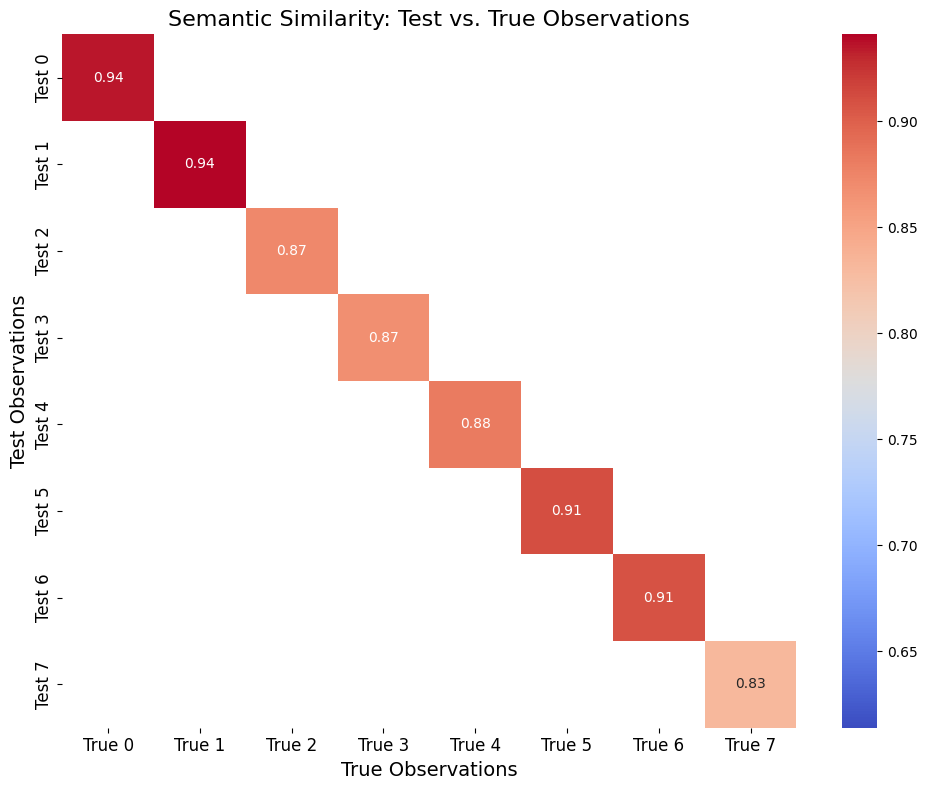

In [ ]:
plt.figure(figsize=(10, 8))
mask = np.zeros_like(similarity_matrix)
diag = ~np.eye(similarity_matrix.shape[0], dtype=bool)
mask[diag] = False

sns.heatmap(similarity_matrix, mask=diag, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=[f"True {i}" for i in range(8)],
            yticklabels=[f"Test {i}" for i in range(8)],
            vmin=similarity_matrix.min(), vmax=similarity_matrix.max())
plt.title("Semantic Similarity: Test vs. True Observations", fontsize=16)
plt.xlabel("True Observations", fontsize=14)
plt.ylabel("Test Observations", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

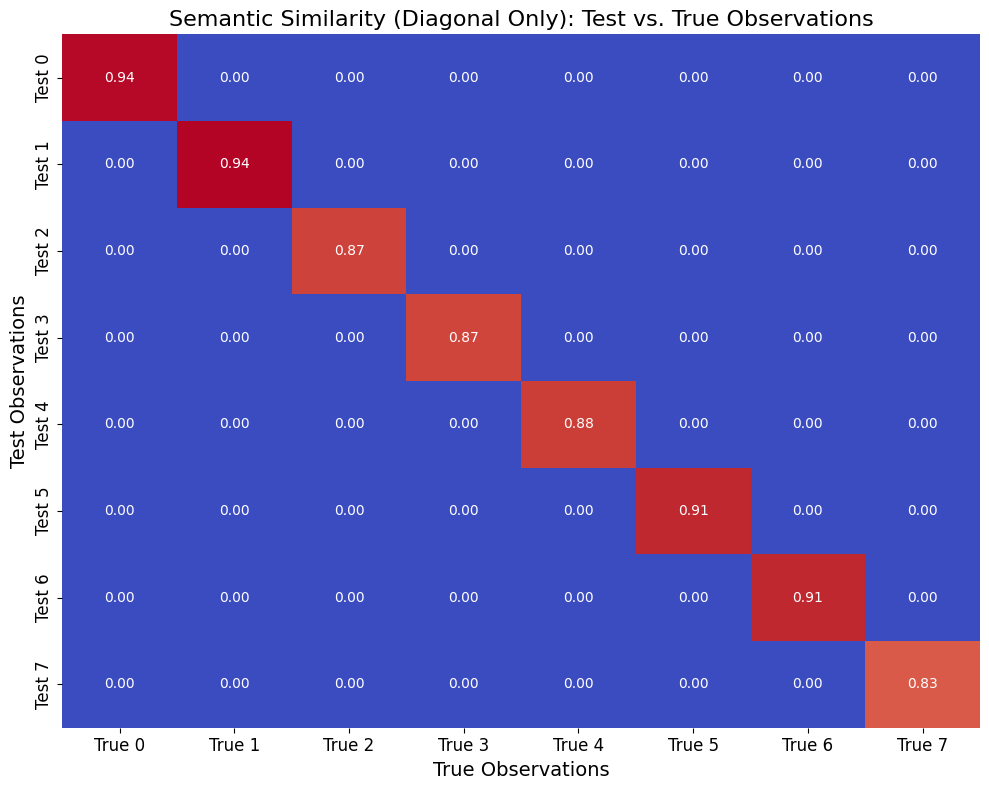

In [ ]:
plt.figure(figsize=(10, 8))
# Keep only the diagonal values
diag_matrix = np.zeros_like(similarity_matrix)
np.fill_diagonal(diag_matrix, np.diag(similarity_matrix))
sns.heatmap(diag_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            xticklabels=[f"True {i}" for i in range(8)],
            yticklabels=[f"Test {i}" for i in range(8)],
            cbar=False)  # No color bar if you want it minimal
plt.title("Semantic Similarity (Diagonal Only): Test vs. True Observations", fontsize=16)
plt.xlabel("True Observations", fontsize=14)
plt.ylabel("Test Observations", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()